<a href="https://colab.research.google.com/github/davidkant/mai/blob/master/tutorial/4_4_Learning_Billie_Jean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#4.4 Learning Billie Jean
Let's work with an actual song. In this notebook we'll learn how to use Markov chains to learn patterns from actual songs and generate new material. We will read in music from the song Billi Jean, train a Markov model, and resynthesize Billie Jean using the trained Markov model. Things get weird quickly...

## Step 1: Install the course code repository
Install external libraries and import them into your notebok session

In [0]:
# install external libraries for sound playback
from IPython.display import clear_output
!pip install -q git+https://github.com/davidkant/mai#egg=mai;
!apt-get -qq update
!apt-get -qq install -y libfluidsynth1
!apt-get install lame
!git clone https://github.com/davidkant/mai.git
clear_output()

In [0]:
# imports
import mai
import random
import pretty_midi
import matplotlib.pyplot as plt
import copy
import IPython.display

## Step 2: Load a MIDI file
First load in a MIDI file of the song Billie Jean. We are using a Python package called `pretty_midi` to read and manipulate MIDI data. I have provided the MIDI file `Billie_Jean.mid` in the `aim80L` Python package.

In [0]:
# load midi file
midi_data = pretty_midi.PrettyMIDI('mai/resources/midi/Billie_Jean.mid')

# and make a copy for our resynthesized version
altered_midi_data = copy.deepcopy(midi_data)

In [0]:
midi_data.instruments

[Instrument(program=53, is_drum=False, name=""),
 Instrument(program=5, is_drum=False, name=""),
 Instrument(program=27, is_drum=False, name=""),
 Instrument(program=28, is_drum=False, name=""),
 Instrument(program=49, is_drum=False, name=""),
 Instrument(program=7, is_drum=False, name=""),
 Instrument(program=63, is_drum=False, name=""),
 Instrument(program=88, is_drum=False, name=""),
 Instrument(program=62, is_drum=False, name=""),
 Instrument(program=28, is_drum=False, name=""),
 Instrument(program=50, is_drum=False, name=""),
 Instrument(program=35, is_drum=False, name=""),
 Instrument(program=0, is_drum=True, name="")]

## Step 3: Select an instrument to work with
MIDI files are often organized with multiple voices or instruments, which are stored in an `instruments` list. Run the cell below to see the instruments list. Hopefully the file you are using names its instruments! Otherwise it'll be difficult to know which voice corresponds to which instrument...

In [0]:
# display all instruments
midi_data.instruments

[Instrument(program=53, is_drum=False, name=""),
 Instrument(program=5, is_drum=False, name=""),
 Instrument(program=27, is_drum=False, name=""),
 Instrument(program=28, is_drum=False, name=""),
 Instrument(program=49, is_drum=False, name=""),
 Instrument(program=7, is_drum=False, name=""),
 Instrument(program=63, is_drum=False, name=""),
 Instrument(program=88, is_drum=False, name=""),
 Instrument(program=62, is_drum=False, name=""),
 Instrument(program=28, is_drum=False, name=""),
 Instrument(program=50, is_drum=False, name=""),
 Instrument(program=35, is_drum=False, name=""),
 Instrument(program=0, is_drum=True, name="")]

Now indicate the instrument you'd like to work with according to its index in the list. 

In [0]:
# instrument to work with
instrument_index = 0

__note:__  Since instruments arn't named in this file, here are a few:

* vocal = `midi_data.instrument[0]`
* drums = `midi_data.instrument[-1]`
* bass = `midi_data.instrument[-2]`
* keys = `midi_data.instrument[-3]`

## Step 4: Extract note pitches
We are going to extract just the pitch information from the vocal melody, turning it into a sequence of numbers representing pitch.

In [0]:
# select instrument from list
instrument = midi_data.instruments[instrument_index]

# extract pitch list
original_music = [note.pitch for note in instrument.notes] # <- don't worry about understanding this line of code just yet

# sanity check 
print(original_music)

[61, 61, 61, 59, 57, 59, 57, 61, 57, 57, 59, 57, 61, 61, 61, 61, 61, 59, 57, 59, 57, 61, 59, 57, 56, 54, 54, 56, 54, 54, 56, 54, 54, 56, 54, 54, 57, 59, 57, 56, 54, 57, 56, 54, 57, 56, 54, 57, 56, 54, 61, 61, 61, 59, 57, 59, 57, 61, 57, 57, 59, 57, 61, 61, 61, 61, 61, 59, 57, 59, 57, 61, 59, 57, 56, 54, 54, 56, 54, 54, 56, 54, 54, 56, 54, 66, 64, 66, 64, 66, 69, 66, 69, 66, 66, 64, 66, 61, 66, 64, 66, 66, 66, 64, 66, 68, 66, 64, 66, 64, 66, 64, 66, 66, 66, 66, 69, 66, 66, 64, 66, 61, 66, 62, 62, 62, 62, 64, 66, 66, 65, 65, 65, 65, 66, 68, 66, 68, 66, 66, 64, 61, 61, 66, 66, 64, 61, 66, 66, 66, 64, 61, 61, 66, 69, 71, 69, 68, 66, 66, 66, 73, 71, 71, 66, 62, 61, 66, 69, 71, 69, 68, 66, 66, 66, 73, 71, 71, 66, 62, 61, 61, 61, 61, 59, 57, 59, 57, 61, 57, 57, 59, 57, 61, 61, 61, 61, 61, 59, 57, 59, 57, 61, 59, 57, 56, 54, 54, 56, 54, 54, 56, 54, 54, 56, 54, 54, 57, 59, 57, 56, 54, 57, 56, 54, 57, 56, 54, 57, 56, 54, 61, 61, 61, 59, 57, 59, 57, 61, 57, 57, 59, 57, 61, 61, 61, 61, 61, 59, 57,

##Step 5: Learn a Markov model from the vocal melody
Train a Markov model on the sequnce of pitches extracted from the vocal meldoy. **This is where you specify what `order` Markov chain  you'd like to use.**

In [0]:
# what order?
order = 3

# create a markov chain instance
mark = mai.markov.Markov()

# then learn a transition table from data
mark.train(original_music, order=order)

View the transition table

In [0]:
# show length of transition table
len(mark.transitions)

100

In [0]:
# show transition table
mark.transitions

{((54, 54, 56), 54): 12,
 ((54, 54, 57), 59): 2,
 ((54, 56, 54), 54): 10,
 ((54, 56, 54), 66): 2,
 ((54, 57, 56), 54): 6,
 ((54, 57, 59), 57): 2,
 ((54, 61, 61), 61): 2,
 ((54, 66, 64), 66): 2,
 ((56, 54, 54), 56): 12,
 ((56, 54, 54), 57): 2,
 ((56, 54, 57), 56): 6,
 ((56, 54, 61), 61): 2,
 ((56, 54, 66), 64): 2,
 ((57, 56, 54), 54): 4,
 ((57, 56, 54), 57): 6,
 ((57, 56, 54), 61): 2,
 ((57, 57, 59), 57): 4,
 ((57, 59, 57), 56): 2,
 ((57, 59, 57), 61): 12,
 ((57, 61, 57), 57): 4,
 ((57, 61, 59), 57): 4,
 ((57, 61, 61), 61): 4,
 ((59, 57, 56), 54): 6,
 ((59, 57, 59), 57): 8,
 ((59, 57, 61), 57): 4,
 ((59, 57, 61), 59): 4,
 ((59, 57, 61), 61): 4,
 ((61, 57, 57), 59): 4,
 ((61, 59, 57), 56): 4,
 ((61, 59, 57), 59): 8,
 ((61, 61, 59), 57): 8,
 ((61, 61, 61), 59): 8,
 ((61, 61, 61), 61): 9,
 ((61, 61, 66), 66): 11,
 ((61, 61, 66), 69): 4,
 ((61, 66, 62), 62): 2,
 ((61, 66, 64), 66): 2,
 ((61, 66, 66), 64): 20,
 ((61, 66, 66), 66): 4,
 ((61, 66, 69), 71): 8,
 ((62, 61, 61), 61): 1,
 ((62, 61,

##Step 6: Generate a new musical sequence from the trained Markov model
Now the fun part, we generate a new vocal melody using the Markov model learned from the original. Note that this cell first sets the initial Markov state to be the first `order` number of notes from the original melody, then generates a new melody with the same number of notes as the original. **Important: you do not need to edit any code in this cell when changing the order.**

In [0]:
# set the initial state
mark.state = tuple(original_music[0:order])

# store new music here
new_music = list(original_music[0:order])

# chose as many notes as in the original
while len(new_music) < len(instrument.notes)-order:
    
    # choose next state (suppress any errors)
    new_state = mark.choose(suppress_errors=True)
        
    # add it to new music
    new_music += [new_state]

**Note:** If your Markov model produces the error `'Current state not found in transition table'`, you can supress it by passing the value `True` to the argument `supress_errors` in the `mark.choose()` function call. 

In [0]:
# print the new music
print(new_music)

[61, 61, 61, 61, 61, 61, 59, 57, 59, 57, 61, 57, 57, 59, 57, 61, 57, 57, 59, 57, 56, 54, 57, 56, 54, 57, 56, 54, 57, 56, 54, 54, 56, 54, 54, 56, 54, 54, 57, 59, 57, 61, 57, 57, 59, 57, 56, 54, 57, 56, 54, 57, 56, 54, 57, 56, 54, 57, 56, 54, 57, 56, 54, 57, 56, 54, 54, 56, 54, 54, 56, 54, 66, 64, 66, 61, 66, 64, 66, 66, 65, 65, 65, 65, 66, 68, 66, 64, 66, 69, 66, 69, 66, 66, 64, 61, 66, 66, 64, 61, 61, 66, 66, 64, 61, 66, 66, 64, 61, 66, 66, 64, 66, 68, 66, 64, 66, 64, 66, 64, 66, 66, 66, 64, 61, 66, 66, 64, 61, 66, 66, 64, 61, 61, 66, 66, 64, 66, 64, 66, 68, 66, 68, 66, 64, 66, 64, 66, 68, 66, 66, 64, 66, 69, 66, 66, 64, 61, 61, 66, 69, 71, 69, 68, 66, 66, 66, 73, 71, 71, 66, 62, 61, 66, 69, 71, 69, 68, 66, 66, 66, 69, 66, 66, 64, 61, 66, 66, 64, 66, 69, 66, 66, 64, 61, 66, 66, 66, 64, 61, 66, 66, 64, 61, 66, 66, 64, 61, 61, 66, 66, 64, 61, 61, 66, 66, 66, 73, 71, 71, 66, 62, 61, 66, 69, 71, 69, 68, 66, 66, 66, 64, 61, 66, 66, 66, 73, 71, 71, 66, 62, 61, 66, 69, 71, 69, 68, 66, 66, 66,

### Plot it
Let's also plot them. Here the the original melody (in blue) and the new melody (in green) are on the same plot. How do they compare?

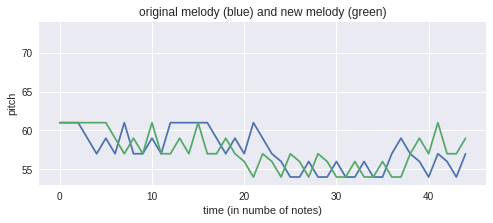

In [0]:
# number of notes to to plot
num_notes = 45

# plot original melody and new melody
plt.figure(figsize=(8,3))
plt.plot(original_music[0:num_notes])
plt.plot(new_music[0:num_notes])
plt.ylim([min(original_music)-1, max(original_music)+1])
plt.xlabel('time (in numbe of notes)')
plt.ylabel('pitch')
plt.title("original melody (blue) and new melody (green)");

##Step 7: Let's hear it
We'll start by resynthesizing the altered voice solo.  Since we've only manipulated pitch, we'll use the rhythm from the original vocal line. This may take a few moments... **Warning!** Turn down your volume before you hit play b/c sometimes the player makes loud static --- usually if you synthesize MIDI into silence.

In [0]:
# loop through original notes and change the pitch
for i,new_pitch in enumerate(new_music):
    instrument.notes[i].pitch = new_pitch
    
# synthesize midi to audio
x = instrument.fluidsynth(fs=22050)

# convert to mp3 and listen
mai.io.play_mp3(x, sr=22050)

Let's add that altered voice to the band and listen to the entire band. We do this by overwriting the voice in `altered_midi_data`, which is a copy of the original midi file we read it in way back at the beginning of this notebook.

In [0]:
# loop through original notes and change the pitch
for i,new_pitch in enumerate(new_music):
    instrument.notes[i].pitch = new_pitch
    
# this time replace the original instrument with your new one
altered_midi_data.instruments[instrument_index] = instrument

# synthesize midi to audio
x = altered_midi_data.fluidsynth(fs=22050)

# convert to mp3 and listen
mai.io.play_mp3(x, sr=22050)

## Step 8: Here's the fun part
Go back and try a few other instruments. Try different orders as well! Can you get a sense for how order affects the resynthesized music?